# Predict the Game Rating

### Introduction

The goal of this blog is to predict the rating of a game given the review.

The implementation includes analysis of the data, cleaning the data, vectorizing and training the model. Hyperparameter tuning by comparing the performance of different models by varying max_features for vectorization has been explained and the best model with the best features has been chosen as the final model for the application.

### Implementation

1. Analyzing the data
2. Cleaning the data
    * Removing non alpha-numeric characters
    * Removing empty rows
3. Sampling the data for train and test
4. Training the model
    * Vectorizing the data - TFIDF, hyperparameter tuning max_features
    * Training the model
5. Testing the model
6. Comparing Classification vs Regression results
7. Building the final model with the best feature count
8. Displaying a sample result

### Concepts Used

1. Stopwords Removal

    Filtering out useless words, using the NLTK in Python, from the data to get meaningful information.
    
2. Sampling Data

    Used random sampling to sample the data to train and test the model. 
    
3. TFIDF Vectorization

    Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. Used this concept to vectorize the data to train the model and also vectorize the test data to test the model.

4. Linear Support Vector Regression - Linear SVR

    Linear SVR is a Support Vector Machine used as a regresion method. Since the ratings are a float LinearSVR was one of the models used to perform the task.
    
    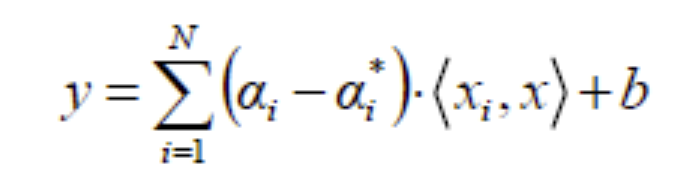

5. Multinomial Naive Bayes Classification

    Multinomial Naive Bayes works with TF-IDF vectors and since Naive Bayes is one of the good classifiers for text analysis, this model is used for the task.    

6. Linear Support Vector Classification - Linear SVC

    Linear SVC is similar to a Support Vector Classification with kernel fixed as linear. This is a classifier that returns the hyperplane that categorizes the data.

### Importing the necessary libraries

In [1]:
import os
import csv
import random
import pickle
import joblib
from datetime import datetime
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

### Path to the required files

In [2]:
review_data = r'D:\UTA Spring 2020 Sem II\CSE 5334\Term Project\boardgamegeek-reviews\bgg-13m-reviews.csv'
clean_data = r'D:\UTA Spring 2020 Sem II\CSE 5334\Term Project\clean_data.csv'
train_data = r'D:\UTA Spring 2020 Sem II\CSE 5334\Term Project\train_data.csv'
sampled_data = r'D:\UTA Spring 2020 Sem II\CSE 5334\Term Project\sampled_data.csv'
test_data = r'D:\UTA Spring 2020 Sem II\CSE 5334\Term Project\test_data.csv'
application_model = r'D:\UTA Spring 2020 Sem II\CSE 5334\Term Project\webapp\model\model_xgboost.joblib'
vectorizer_dump = r'D:\UTA Spring 2020 Sem II\CSE 5334\Term Project\webapp\model\vectorizer.joblib'

### Analysing the data provided

The dataset provided is a 1.16 GB folder comprising of three csv files. This is a very large dataset to process all at once. I have made use of the bgg-13m-reviews.csv file which contains the user comments and ratings for different games. The first few rows of the csv file have been displayed below

In [3]:
data = pd.read_csv(review_data, nrows=5)
print(data)

   Unnamed: 0         user  rating  \
0           0   sidehacker    10.0   
1           1  Varthlokkur    10.0   
2           2   dougthonus    10.0   
3           3       cypar7    10.0   
4           4      ssmooth    10.0   

                                             comment  ID   name  
0                                                NaN  13  Catan  
1                                                NaN  13  Catan  
2  Currently, this sits on my list as my favorite...  13  Catan  
3  I know it says how many plays, but many, many ...  13  Catan  
4                                                NaN  13  Catan  


### Observations from the analysis

The first few rows review data provided in the csv format by BoardGameGeek can be seen above.

There are a few columns in the file which are not required for predicting the rating of a game. Predicting the game rating using the user's name as a criteria is not a good approach. Game name or Game ID are not good parameters to predict the game rating.

One of the good parameters to predict the rating of a game is the user comment. There are many rows in the csv which have rating but no user comment. These are the non essential rows.

In [4]:
with open(review_data, encoding='utf-8') as fileObj:
    row_count = sum(1 for row in fileObj)
print(row_count)

13170074


### Processing the data

The review csv has 13,170,074 (about 13.1 million) rows and file is 1.09 GB in size. Considering the limited memory and limitations of the processor, I have processed the file by spitting it into chunks of size 100000 and have used only the **rating** and **comment** columns.

Data cleaning needs to be done to improve the performance performance. The non alpha-numeric characters and URLs need to be removed from the data to get meaningful information. Data is cleaned using the below process:
* Splitting the csv file into chunks of 100,000
* Removing the URLs from the comment column - URLs are unessential as the tell us almost nothing about the rating
* Removing @'s and any domain following '@'
* Removing all charactes except alphabets and digits
* Converting all the text to lowercase - This helps in reducing redundancy in the data
* Stripping all extra spaces - There could be comments with random special characters and cleaning special characters might end up leaving that particular comment with just spaces. Stripping all non essential spaces is also essential.

The next step is removing the rows which have no comment, since predicting the rating from a comment in such a case is not possible.

In [5]:
def removeNonAlphaNumChars(review_data, train_data):
    columns_req = ['rating','comment']
    add_header = True
    if os.path.exists(clean_data):
        os.remove(clean_data)
    for chunk in pd.read_csv(review_data, chunksize=100000, usecols=columns_req):       
        chunk.iloc[:, 1] = chunk.iloc[:, 1].str.replace(r"http\S+", "")
        chunk.iloc[:, 1] = chunk.iloc[:, 1].str.replace(r"http", "")
        chunk.iloc[:, 1] = chunk.iloc[:, 1].str.replace(r"@\S+", "")
        chunk.iloc[:, 1] = chunk.iloc[:, 1].str.replace(r"[^a-zA-Z\d\s\']+", " ")
        chunk.iloc[:, 1] = chunk.iloc[:, 1].str.lower()
        chunk.iloc[:, 1] = chunk.iloc[:, 1].str.strip()
        chunk.to_csv(clean_data, mode='a', index=False, header=add_header)
        if add_header:
            # The header should not be printed more than one
            add_header = False

def removeRowsMissingColVals(train_data):
    columns_req = ['rating','comment']
    add_header = True
    stop = stopwords.words('english')
    pat = r'\b(?:{})\b'.format('|'.join(stop))
    if os.path.exists(train_data):
        os.remove(train_data)
    for chunk in pd.read_csv(clean_data, chunksize=100000, usecols=columns_req):
        chunk_del = chunk.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
        chunk_del.to_csv(train_data, mode='a', index=False, header=add_header)
        if add_header:
            # The header should not be printed more than one
            add_header = False

def roundOf(rating):
    return round(rating * 2) / 2

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [6]:
removeNonAlphaNumChars(review_data, train_data)
removeRowsMissingColVals(train_data)

### Cleaned data

The cleaned data, after the removal of non alpha-numeric characters, URLs, extra spaces and empty rows, is collected in a file.

In [7]:
with open(train_data, encoding='utf-8') as fileObj:
    row_count = sum(1 for row in fileObj)
print(row_count)

2615951


The cleaned data file has **2,615,951 (about 2.6 million)** rows. There is a significant reduction in the size of the dataset after cleaning the dataset.

In [8]:
train_df = pd.read_csv(train_data)
count_r = train_df['rating'].nunique()
print('There are almost {} distinct ratings in the training data.'.format(count_r))

There are almost 3405 distinct ratings in the training data.


There are 3405 distinct values for the ratings. For consistency, the ratings have been rounded off to the nearest multiple of 0.5 or 1 for regressor and classifier respectively for the next steps.

### Collecting Training and Test Data

Training Data is collected by randomly sampling data from the cleaned data. This is about **10 %** for the cleaned data.

Test Data is collected by removing all the data that was sampled for training from the dataset. This test data is being used for testing the model by dividing it into chunks of size 100,000.

In [9]:
def sampleTrainingData(train_data):
    n = sum(1 for line in open(train_data, encoding='utf-8'))-1  # Calculate number of rows in file
    s = n//10  # sample size of 10%
    skip = sorted(random.sample(range(1, n+1), n-s))  # n+1 to compensate for header
    sampled_df = pd.read_csv(train_data, skiprows=skip)
    
    #def roundOf(rating):
    #    return round(rating * 2) / 2
    sampled_df.iloc[:, 0] = roundOf(sampled_df.iloc[:, 0])
    if os.path.exists(sampled_data):
        os.remove(sampled_data)
    sampled_df.to_csv(sampled_data, encoding='utf-8', index=False)
    
    stop = stopwords.words('english')
    sampled_df['comment'] = sampled_df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    print('Sampled Dataframe : \n', sampled_df)
    comments = sampled_df['comment'].tolist()
    ratings = sampled_df['rating'].tolist()
    return(sampled_df, comments, ratings, skip, n)

def collectTestData(train_data, skipped, test_data, n):
    new_n = len(set(range(1, n+1)))//10
    test_consider = random.sample(skipped, new_n)
    new_skip = set(range(1, n+1)) - set(test_consider)
    test_df = pd.read_csv(train_data, skiprows=new_skip)
    print('Test Dataframe : \n', test_df)
    
    test_df.iloc[:, 0] = roundOf(test_df.iloc[:, 0])
    test_df = test_df.sample(frac=1)
    if os.path.exists(test_data):
        os.remove(test_data)
    test_df.to_csv(test_data, encoding='utf-8', index=False)
    return(test_df, test_data)

In [10]:
sampled_df, comments, ratings, skip, n = sampleTrainingData(train_data)
test_df, test_data = collectTestData(train_data, skip, test_data, n)

Sampled Dataframe : 
         rating                                            comment
0         10.0                  currently sits list favorite game
1         10.0                played game new classic gather dust
2         10.0   seafarers expansion near perfect game must gamer
3         10.0  one great ones course played game sick far des...
4         10.0  quot hall fame quot game simple rules fast pac...
...        ...                                                ...
261590     2.0  rating based played adults perhaps children wo...
261591     6.5  material great proves quality possible game fu...
261592     4.0  great idea moving board rules issues long bori...
261593     3.0  maybe expected something different global warm...
261594     7.0                                   old scooled game

[261595 rows x 2 columns]
Test Dataframe : 
         rating                                            comment
0         10.0  this is a great game   i've even got a number ...
1       

#### The 10 most common words in the Sampled Training Data

In [11]:
print(Counter(' '.join(sampled_df["comment"]).split()).most_common(10)[:10])

[('game', 257591), ('play', 75490), ('like', 53367), ('fun', 52144), ('one', 48560), ('good', 40352), ('games', 38612), ('players', 36666), ('really', 36366), ('played', 35306)]


### Vectorizing the data

**Hyperparameter Tuning - max_features**

Training data and Test data is vectorized using different number of max features. 

Model is trained and tested by limiting the value of max features to 500, 10000 and 20000 respectively. The performance of varying the max_features has been compared in the following steps.

In [12]:
def vectorizeData(comments, n_features):
    print('\nFeatures : ', n_features)
    vectorizer = TfidfVectorizer(max_features=n_features)
    # the 'fit' builds up the vocabulary from all the reviews
    vectors = vectorizer.fit_transform(comments)
    return(vectorizer, vectors)

def vectorizeTestData(vectorizer, comments):
    # the 'transform' step turns each indivdual text into
    # a matrix of numbers.
    vectors = vectorizer.transform(comments)
    return(vectors)

### Training the Model - Support Vector Regressor (SVR)

Since the ratings are a float value rounded to the nearest multiple of 0.5 I have trained my model using **linear** varient of the SVR.

In [13]:
def trainModel(vectors, ratings):
    # initialise the SVM classifier
    classifier = LinearSVR()    
    # train the classifier
    classifier.fit(vectors, ratings)
    return(classifier)

def testModel(vectorizer, classifier, test_data, n_features):
    count = 1
    chunk_rmse = {}
    accuracy_chunk_svr = {}
    for chunk in pd.read_csv(test_data, chunksize=50000):
        #print('Performing testing on Test Chunk :', count)
        test_df = chunk
        test_comments = test_df['comment'].tolist()
        test_ratings = test_df['rating'].tolist()
        test_vectors = vectorizeTestData(vectorizer, test_comments)
        preds = classifier.predict(test_vectors)
        preds_rounded = [roundOf(num) for num in preds]
        #print(list(preds_rounded[:10]))
        #print(test_ratings[:10])
        test_ratings_int = list(map(int, test_ratings))
        preds_int = list(map(int, preds))
        accuracy = accuracy_score(test_ratings_int, preds_int, normalize=True) * float(100)
        rmse_test = mean_squared_error(test_ratings, preds, squared=False)
        accuracy_chunk_svr[count] = accuracy
        chunk_rmse[count] = rmse_test
        #print(accuracy)
        #print(rmse_test)
        count = count + 1
    print('Model tested on {} chunks of test data.'.format(count-1))
    average_accuracy_svr = np.array(list(accuracy_chunk_svr.values())).mean()
    average_rmse = np.array(list(chunk_rmse.values())).mean()
    return(average_accuracy_svr, average_rmse)

Model linear SVR is trained and tested using max_features value as 500, 10000 and 20000.

In [14]:
features = [500, 10000, 20000]
feature_rmse = {}
accuracy_features_svr = {}
for n_features in features:
    vectorizer, train_vectors = vectorizeData(comments, n_features)
    classifier = trainModel(train_vectors, ratings)
    print('Model trained.')
    accuracy_features_svr[n_features], feature_rmse[n_features] = testModel(vectorizer, classifier, test_data, n_features)


Features :  500
Model trained.
Model tested on 6 chunks of test data.

Features :  10000
Model trained.
Model tested on 6 chunks of test data.

Features :  20000
Model trained.
Model tested on 6 chunks of test data.


#### Accuracy and RMSE for Linear SVR

For the different max_features values, the performance of the model has been compared and displayed below.

In [15]:
result_LinearSVR = pd.DataFrame(columns=['Accuracy', 'RMSE'], index=features)
result_LinearSVR['Accuracy'] = accuracy_features_svr.values()
result_LinearSVR['RMSE'] = feature_rmse.values()
print('Statistics for LinearSVR : \n', result_LinearSVR)

print('\nBest number of features according to Accuracy : ', max(accuracy_features_svr, key=accuracy_features_svr.get))
print('\nBest number of features according to RMSE : ', min(feature_rmse, key=feature_rmse.get))

Statistics for LinearSVR : 
         Accuracy      RMSE
500    26.005950  1.602167
10000  24.616946  1.531298
20000  26.717797  1.569466

Best number of features according to Accuracy :  20000

Best number of features according to RMSE :  10000


### Classification

Since classification cannot be done on float values the ratings have been rounded to the nearest integer. Performance of Multinomial Naive Bayes and Linear Support Vector Classification has been compared below.

Frequency of Ratings of Comments in the Training data is shown in the bar plot below

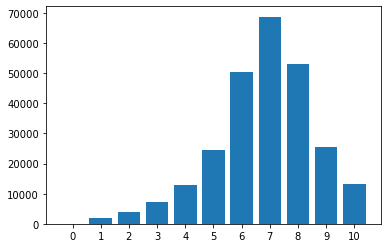

In [16]:
rate_list = sorted(test_df['rating'].astype('int').tolist())
dict_rate = dict(Counter(rate_list))
plt.bar(range(len(dict_rate)), list(dict_rate.values()), align='center')
plt.xticks(range(len(dict_rate)), list(dict_rate.keys()))
plt.show()

In [17]:
def trainClassificationModel(sampled_df, n_features, model):
    print('\nTraining the Model :', model)
    print('Features : ', n_features)
    if model == 'MultinomialNB':
        training_model = make_pipeline(TfidfVectorizer(max_features=n_features), MultinomialNB())
    else:
        training_model = make_pipeline(TfidfVectorizer(max_features=n_features), LinearSVC())
    training_model.fit(sampled_df['comment'], sampled_df['rating'].astype('int'))
    return(training_model)

def testClassificationModel(training_model, test_data, n_features):
    count = 1
    chunk_accuracy = {}
    chunk_rmse_classification = {}
    for chunk in pd.read_csv(test_data, chunksize=50000):
        #print('Performing testing on Test Chunk :', count)
        test_df = chunk
        preds_classification = training_model.predict(test_df['comment'])
        accuracy_test = accuracy_score(test_df['rating'].astype('int'), preds_classification, normalize=True) * float(100)
        rmse_test_classification = mean_squared_error(test_df['rating'].astype('int'), preds_classification, squared=False)
        chunk_accuracy[count] = accuracy_test
        chunk_rmse_classification[count] = rmse_test_classification
        #print(accuracy_test)
        #print(rmse_test_classification)
        count = count + 1
    print('Model tested on {} chunks of test data.'.format(count-1))
    average_accuracy = np.array(list(chunk_accuracy.values())).mean()
    average_rmse = np.array(list(chunk_rmse_classification.values())).mean()
    return(average_accuracy, average_rmse)

In [18]:
features = [500, 10000, 20000]
model = ['MultinomialNB', 'LinearSVC']
features_accuracy_svc = {'MultinomialNB': {}, 'LinearSVC': {}}
features_rmse_svc = {'MultinomialNB': {}, 'LinearSVC': {}}
for m in model:
    for n_features in features:
        training_model = trainClassificationModel(sampled_df, n_features, m)
        print('Model trained.')
        features_accuracy_svc[m][n_features] = testClassificationModel(training_model, test_data, n_features)


Training the Model : MultinomialNB
Features :  500
Model trained.
Model tested on 6 chunks of test data.

Training the Model : MultinomialNB
Features :  10000
Model trained.
Model tested on 6 chunks of test data.

Training the Model : MultinomialNB
Features :  20000
Model trained.
Model tested on 6 chunks of test data.

Training the Model : LinearSVC
Features :  500
Model trained.
Model tested on 6 chunks of test data.

Training the Model : LinearSVC
Features :  10000
Model trained.
Model tested on 6 chunks of test data.

Training the Model : LinearSVC
Features :  20000
Model trained.
Model tested on 6 chunks of test data.


In [19]:
accuracy_MultinomialNB = []
accuracy_LinearSVC = []
rmse_MultinomialNB = []
rmse_LinearSVC = []
for key in features_accuracy_svc['MultinomialNB'].keys():
    accuracy_MultinomialNB.append(features_accuracy_svc['MultinomialNB'][key][0])
    rmse_MultinomialNB.append(features_accuracy_svc['MultinomialNB'][key][1])
for key in features_accuracy_svc['LinearSVC'].keys():
    accuracy_LinearSVC.append(features_accuracy_svc['LinearSVC'][key][0])
    rmse_LinearSVC.append(features_accuracy_svc['LinearSVC'][key][1])

#### Accuracy and RMSE for Multinomial Naive Bayes

For the different max_features values, the performance of the model has been compared and displayed below.

In [20]:
result_MultinomialNB_df = pd.DataFrame(columns=['Accuracy', 'RMSE'], index=features)
result_MultinomialNB_df['Accuracy'] = accuracy_MultinomialNB
result_MultinomialNB_df['RMSE'] = rmse_MultinomialNB
print('Statistics for MultinomialNB : \n', result_MultinomialNB_df)

print('\nBest number of features according to', result_MultinomialNB_df[['Accuracy']].idxmax())
print('\nBest number of features according to', result_MultinomialNB_df[['RMSE']].idxmin())

Statistics for MultinomialNB : 
         Accuracy      RMSE
500    28.698199  1.690716
10000  28.927255  1.660024
20000  28.043391  1.720749

Best number of features according to Accuracy    10000
dtype: int64

Best number of features according to RMSE    10000
dtype: int64


#### Accuracy and RMSE for Linear Support Vector Classification

For the different max_features values, the performance of the model has been compared and displayed below.

In [21]:
result_LinearSVC_df = pd.DataFrame(columns=['Accuracy', 'RMSE'], index=features)
result_LinearSVC_df['Accuracy'] = accuracy_LinearSVC
result_LinearSVC_df['RMSE'] = rmse_LinearSVC
print('Statistics for LinearSVC : \n', result_LinearSVC_df)

print('\nBest number of features according to', result_LinearSVC_df[['Accuracy']].idxmax())
print('\nBest number of features according', result_LinearSVC_df[['RMSE']].idxmin())

Statistics for LinearSVC : 
         Accuracy      RMSE
500    29.897850  1.674700
10000  28.199325  1.689126
20000  26.254678  1.898977

Best number of features according to Accuracy    500
dtype: int64

Best number of features according RMSE    500
dtype: int64


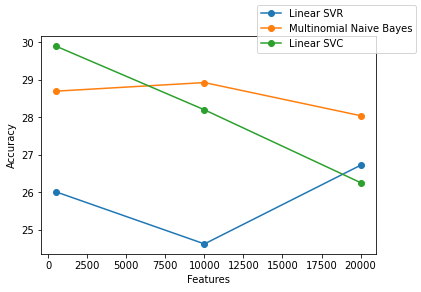

In [22]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(result_LinearSVR['Accuracy'], label='Linear SVR', marker = 'o')
ax1.plot(result_MultinomialNB_df['Accuracy'], label='Multinomial Naive Bayes', marker = 'o')
ax1.plot(result_LinearSVC_df['Accuracy'], label='Linear SVC', marker = 'o')
fig1.legend()
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.show()

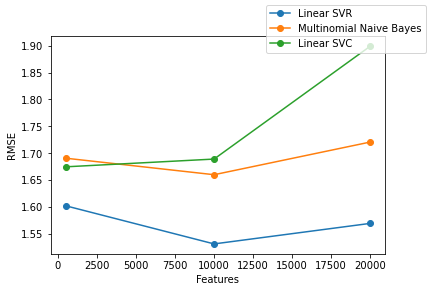

In [23]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.plot(result_LinearSVR['RMSE'], label='Linear SVR', marker = 'o')
ax1.plot(result_MultinomialNB_df['RMSE'], label='Multinomial Naive Bayes', marker = 'o')
ax1.plot(result_LinearSVC_df['RMSE'], label='Linear SVC', marker = 'o')
fig1.legend()
plt.xlabel('Features')
plt.ylabel('RMSE')
plt.show()

### Final Observation

It is good to consider **RMSE** as a parameter to decide on the model since we cannot just rely on Accuracy.

Accuracy counts towards the exactness of the prediction. When we consider a review which has actual rating of 7 and the model predicted a rating of 6.5 or an 8, the model can be considered to have performed well, but this performance would not reflect when the accuracy is measured.

On the other hand, RMSE is a parameter measuring the error in terms of the difference between the actual and the predicted values and seems to be a better parameter to consider for this task.

**Considering the RMSE as the deciding factor for the model performance, Linear SVR is seen to perform much better than the other two models. The model performed best with max_features value as 10000. 500 features seemed to be too less and RMSE was high. Considering the case of 20000 features, it did not prove to be better than 10000 features in terms of RMSE or Accuracy, instead it took a little longer to vectorize data.**

Finally LinearSVR model is used along with 10000 features for the task.

In [24]:
best_features = 10000
vectorizer, train_vectors = vectorizeData(comments, best_features)
classifier = trainModel(train_vectors, ratings)
print('Model trained.')

joblib.dump(classifier, application_model)
joblib.dump(vectorizer, vectorizer_dump)
print('Model is ready to be tested.')


Features :  10000
Model trained.
Model is ready to be tested.


### Finally testing the model

The model did a good job of predicting rating for the review input.

In [25]:
my_comment = ['Enjoyed playing the awesome game.']
my_comment_vectors = vectorizer.transform(my_comment)
my_comment_preds = classifier.predict(my_comment_vectors)
print('Game Rating is :', roundOf(my_comment_preds[0]))

Game Rating is : 7.5


### Improvements and Contribution

This implementation includes sampling from a large dataset and then training a model to predict rating, given the review. Training data has been vectorized using varying max_features as a criteria (hyperparameter) which is a new thing implemented.

The existing implementations only implement classifiers. Comparison the performance of a Regressor and Classifiers for predicting the rating has been done in this implementation.

Instead of counting accuracy as a parameter, RMSE has been used to compare model performances. Accuracies did not tell much about the performance model and it was almost similar for the three models.

From the implementation it was observed that the Linear SVR performed better than the Multinomial Naive Bayes Classifier and Linear SVC. SVR and SVC are both support vector machines but SVC was much slower than the SVC.

### Challenges

1. Analyzing the dataset to decide which parameters to use to predict the rating was an important decision made.

2. Reading a large data set was one of the challenges which was overcome by using random sampling. 10% of the cleaned and processed dataset was used for training the models.

3. There were about 3000+ distinct values for rating. Rounding the rating to multiples of 0.5 for Regressor and nearest integer for Classifier was done to overcome this challenge.

4. Picking a metric to measure the performance of the models was another challenge since the accuracy for almost same for all models and it was quiet low. It was observed that RMSE was a better metric to measure performance of the model than Accuray, since accuracy takes into considering the exactness which is not the case in RMSE.

### References

https://www.codementor.io/@guidotournois/4-strategies-to-deal-with-large-datasets-using-pandas-qdw3an95k
for picking random sample from training data

https://stackoverflow.com/questions/24838629/round-off-float-to-nearest-0-5-in-python
for rounding rating

https://stackoverflow.com/questions/47917943/how-to-select-several-rows-when-reading-a-csv-file-using-pandas
for skipping rows while reading from a csv

https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
for removing stopwords

https://www.developintelligence.com/blog/2017/03/predicting-yelp-star-ratings-review-text-python/
as a reference

https://towardsdatascience.com/review-rating-prediction-a-combined-approach-538c617c495c
as a reference